In [1]:
G_path = '/Users/sepehrbe/My_Drive/DataSources/SkinCare'
import pandas as pd
import seaborn as sns
from sklearn import *
import sklearn as sk
from sklearn import *
import numpy as np
from scipy.stats import chi2_contingency
import datetime as dt
import pickle
import torch
import json
import random
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from MLP_Nets import MLP_Nets

from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from usefull_functions import *
import time
from statistics import mean
import warnings
warnings.filterwarnings('ignore')

In [2]:
file = 'CNN_280x210_Ouput' 
# file = 'DataSource_60x45_Ordinal_CNN.pickle' 
data = pd.read_pickle(G_path + '/CNN_Output/' + file)

blc_test_list = pickle.load(open(G_path + 'blc_test_meta_list','rb'))
# Evaluation_set = pickle.load(open(G_path + '/DataSet_280x210/' + file,'rb'))

train_data = data[data.type=='train']
valid_data = data[data.type=='valid']
test_data = data[data.type=='test']
blc_test_data = data.merge(blc_test_list['image_id'], how='inner',on='image_id')


train_label = train_data['image_label']
train_data = train_data.drop(columns=['image_id','image_label','dx','lesion_id','type'])
valid_label = valid_data['image_label']
valid_data = valid_data.drop(columns=['image_id','image_label','dx','lesion_id','type'])
test_label = test_data['image_label']
test_data = test_data.drop(columns=['image_id','image_label','dx','lesion_id','type'])
blc_label = blc_test_data['image_label']
blc_data = blc_test_data.drop(columns=['image_id','image_label','dx','lesion_id','type'])

####### Feature Selection #################
# features = ['CNN_0', 'CNN_1', 'CNN_2','CNN_3', 'CNN_4', 'CNN_5', 'CNN_6']
# train_data = train_data[features]
# valid_data = valid_data[features]
# test_data = test_data[features]

####### Feature Selection #################
# features = ['CNN_0', 'CNN_1', 'CNN_2','CNN_3', 'CNN_4', 'CNN_5', 'CNN_6','age','localization_back','localization_face','localization_lower extremity','dx_type_consensus','dx_type_follow_up','dx_type_histo']
# train_data = train_data[features]
# valid_data = valid_data[features]
# test_data = test_data[features]

####### Feature Selection #################
# features = ['CNN_0', 'CNN_1', 'CNN_2','CNN_3', 'CNN_4', 'CNN_5', 'CNN_6','age','localization','dx_type']
# train_data = train_data[features]
# valid_data = valid_data[features]
# test_data = test_data[features]

train_data_arrays = np.stack(train_data.values)  
train_label_arrays = np.stack(train_label.values)
train_label_arrays_One = pd.get_dummies(train_label_arrays).values  

valid_data_arrays = np.stack(valid_data.values)  
valid_label_arrays = np.stack(valid_label.values)  
valid_label_arrays_One = pd.get_dummies(valid_label_arrays).values  

test_data_arrays = np.stack(test_data.values)  
test_label_arrays = np.stack(test_label.values)  
test_label_arrays_One = pd.get_dummies(test_label_arrays).values  

blc_data_arrays = np.stack(blc_data.values)  
blc_label_arrays = np.stack(blc_label.values)  
blc_label_arrays_One = pd.get_dummies(blc_label_arrays).values 

#Numpy Arrays
input_data_Array = (train_data_arrays , valid_data_arrays, test_data_arrays , np.concatenate((train_data_arrays,valid_data_arrays )))
labels_Array = (train_label_arrays,valid_label_arrays,test_label_arrays, np.concatenate((train_label_arrays,valid_label_arrays)))
labels_One_Array = (train_label_arrays_One,valid_label_arrays_One,test_label_arrays_One, np.concatenate((train_label_arrays_One,valid_label_arrays_One)))

# Tensors
def to_Torch(x):
    return torch.tensor(x,dtype= torch.float32)

input_data_Tensor = (to_Torch(train_data_arrays),to_Torch(valid_data_arrays)  , to_Torch(test_data_arrays) , to_Torch(np.concatenate((train_data_arrays,valid_data_arrays))))
labels_Tensor = (to_Torch(train_label_arrays),to_Torch(valid_label_arrays),to_Torch(test_label_arrays) , to_Torch(np.concatenate((train_label_arrays,valid_label_arrays))) )
labels_OneHot_Tensor = (to_Torch(train_label_arrays_One),to_Torch(valid_label_arrays_One),to_Torch(test_label_arrays_One), to_Torch(np.concatenate((train_label_arrays_One,valid_label_arrays_One))))

blc_data_Tensor = (to_Torch(blc_data_arrays))

# **Random Forrest**

In [10]:
Model_ = sk.ensemble.RandomForestClassifier(random_state=0, n_jobs=-1)
K_Folds = sk.model_selection.KFold(n_splits=10, shuffle=True)

kfold_per_param_search = False

# grid = { 
#     'n_estimators': [100,200,500],
#     'max_features': ['auto', 'log2'],
#     'max_depth' : [4,7,10,20],
#     'criterion' :['gini', 'entropy'],
#     'bootstrap': [True, False],
#     'class_weight' : [None, 'balanced'],
#     'max_leaf_nodes' : [3,5,None],
# }

grid = { 
    'n_estimators': [100, 200],
    'max_features': ['auto', 'log2'],
    'max_depth' : [20,30],
    'criterion' :['gini', 'entropy'],
    'bootstrap': [False],
    'class_weight' : [None, 'balanced'],
    'max_leaf_nodes' : [5,None],
}

test_scores = []
Param_Details = pd.DataFrame(columns=['hyper_param','test_accuracy','test_fscore','test_precision','test_recall'])

training_data = input_data_Array[0]
training_label = labels_Array[0]
x_test = input_data_Array[2]
y_test = labels_Array[2]

pbar = tqdm (sk.model_selection.ParameterGrid(grid))
for g in pbar:

    test_accuracy = []
    test_fscore = []
    test_precision = []
    test_recall = []

    if kfold_per_param_search:

        for fold, (train_index, test_index) in enumerate(K_Folds.split(training_data[2],training_label[2])):
            x_train_ = training_data[2][train_index]
            y_train_ = training_label[2][train_index]
            x_test_ = training_data[2][test_index]
            y_test_ = training_label[2][test_index]
            
            Model_.set_params(**g)
            Model_.fit(x_train_, y_train_)
            Y_pred = Model_.predict(x_test_)
            Y = y_test_

            precision_, recall_, fscore_, m = sk.metrics.precision_recall_fscore_support(Y_pred,Y , average = 'weighted')
            acc_ = sk.metrics.accuracy_score(Y_pred,Y )
            test_accuracy.append(acc_)
            test_fscore.append(fscore_)
            test_precision.append(precision_)
            test_recall.append(recall_)
            new_row = pd.Series({'hyper_param':g,'test_accuracy':test_accuracy,'test_fscore':test_fscore,'test_precision':test_precision,'test_recall':test_recall}, name='')
            Param_Details = Param_Details.append(new_row)
    else:
            x_train_ = training_data
            y_train_ = training_label
            x_test_ = x_test
            y_test_ = y_test
            
            Model_.set_params(**g)
            Model_.fit(x_train_, y_train_)
            Y_pred = Model_.predict(x_test_)
            Y = y_test_

            precision_, recall_, fscore_, m = sk.metrics.precision_recall_fscore_support(Y_pred,Y , average = 'weighted')
            acc_ = sk.metrics.accuracy_score(Y_pred,Y )
            test_accuracy.append(acc_)
            test_fscore.append(fscore_)
            test_precision.append(precision_)
            test_recall.append(recall_)
            new_row = pd.Series({'hyper_param':g,'test_accuracy':test_accuracy,'test_fscore':test_fscore,'test_precision':test_precision,'test_recall':test_recall}, name='')
            Param_Details = Param_Details.append(new_row)

Param_Details['test_accuracy_avg'] = Param_Details.apply(lambda x: mean(x.test_accuracy),axis=1)
Param_Details['test_fscore_avg'] = Param_Details.apply(lambda x: mean(x.test_fscore),axis=1)
Param_Details['test_precision_avg'] = Param_Details.apply(lambda x: mean(x.test_precision),axis=1)
Param_Details['test_recall_avg'] = Param_Details.apply(lambda x: mean(x.test_recall),axis=1)
Param_Details['test_accuracy_max'] = Param_Details.test_accuracy.apply(max)
Param_Details['test_fscore_max'] = Param_Details.test_fscore.apply(max)
Param_Details['test_precision_max'] = Param_Details.test_precision.apply(max)
Param_Details['test_recall_max'] = Param_Details.test_recall.apply(max)
RF_param_details = Param_Details
best_one = np.argmax(RF_param_details.test_fscore_avg)
best_param = RF_param_details.iloc[best_one]['hyper_param']
RF_Model = Model_.set_params(**best_param)
RF_Model.fit(training_data, training_label)
Y_pred = RF_Model.predict(x_test)

RF_param_details['hyper_param'] = RF_param_details['hyper_param'].apply(lambda x: json.dumps(x))
print('------- Precision recal %--------')
print(sk.metrics.classification_report(y_test,Y_pred))
print('Best param: ' , best_param)

100%|██████████| 64/64 [00:09<00:00,  6.76it/s]


------- Precision recal %--------
              precision    recall  f1-score   support

           0       0.52      0.65      0.58        23
           1       0.59      0.75      0.66        32
           2       0.60      0.68      0.64        72
           3       0.67      0.50      0.57         8
           4       0.54      0.47      0.50        62
           5       0.89      0.83      0.86       200
           6       1.00      0.90      0.95        10

    accuracy                           0.73       407
   macro avg       0.69      0.68      0.68       407
weighted avg       0.74      0.73      0.73       407

Best param:  {'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': 30, 'max_features': 'auto', 'max_leaf_nodes': None, 'n_estimators': 200}


Nr. of Data : 
 105
Accuracy of The Model : 
 0.6190476190476191


,weights,Precision,Recall_Sensitivity,Specificity,f1_score
0,14.3%,80.0%,53.3%,97.8%,64.0%
1,14.3%,62.5%,66.7%,93.3%,64.5%
2,14.3%,38.5%,66.7%,82.2%,48.8%
3,14.3%,100.0%,40.0%,100.0%,57.1%
4,14.3%,57.1%,53.3%,93.3%,55.2%
5,14.3%,47.4%,60.0%,88.9%,52.9%
6,14.3%,100.0%,93.3%,100.0%,96.6%
Simple Avg.,nan%,69.4%,61.9%,93.7%,62.7%
Weighted Avg.,nan%,69.4%,61.9%,93.7%,62.7%


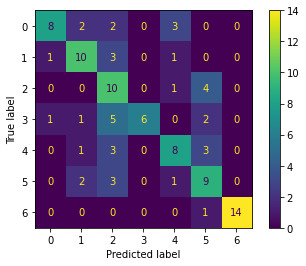

In [12]:
# Model 280x210
model_ = RF_Model
X = input_data_Array[2]
Y = labels_Array[2]
X = blc_data_arrays
Y = blc_label_arrays
Y_pred = model_.predict(X)
Y_binary =  label_to_binary(Y)
Y_pred_binary =  label_to_binary(Y_pred)
results = model_evaluation(Y,Y_pred)
# results = model_evaluation(Y_binary,Y_pred_binary)
results

# **SVM**

In [70]:
Model_ = sk.svm.SVC(random_state=0)
K_Folds = sk.model_selection.KFold(n_splits=10, shuffle=True)

kfold_per_param_search = False

grid = { 
    'C' : [2,5,8,10]
    ,'kernel': ['rbf', 'linear'],
    'degree' : [1,2,3,7],
    'gamma' :['scale', 'auto'],
    'decision_function_shape': ['ovo', 'ovr'],
    'class_weight' : [None, 'balanced']
}

# grid = { 
#     'C' : [5]
#     ,'kernel': ['rbf', 'linear'],
#     'degree' : [3],
#     'gamma' :['scale', 'auto'],
#     'decision_function_shape': ['ovo', 'ovr'],
#     'class_weight' : [None, 'balanced']
# }

test_scores = []
Param_Details = pd.DataFrame(columns=['hyper_param','test_accuracy','test_fscore','test_precision','test_recall'])

training_data = input_data_Array[0]
training_label = labels_Array[0]
x_test = input_data_Array[2]
y_test = labels_Array[2]

pbar = tqdm (sk.model_selection.ParameterGrid(grid))
for g in pbar:

    test_accuracy = []
    test_fscore = []
    test_precision = []
    test_recall = []

    if kfold_per_param_search:

        for fold, (train_index, test_index) in enumerate(K_Folds.split(training_data[2],training_label[2])):
            x_train_ = training_data[2][train_index]
            y_train_ = training_label[2][train_index]
            x_test_ = training_data[2][test_index]
            y_test_ = training_label[2][test_index]
            
            Model_.set_params(**g)
            Model_.fit(x_train_, y_train_)
            Y_pred = Model_.predict(x_test_)
            Y = y_test_

            precision_, recall_, fscore_, m = sk.metrics.precision_recall_fscore_support(Y_pred,Y , average = 'weighted')
            acc_ = sk.metrics.accuracy_score(Y_pred,Y )
            test_accuracy.append(acc_)
            test_fscore.append(fscore_)
            test_precision.append(precision_)
            test_recall.append(recall_)
            new_row = pd.Series({'hyper_param':g,'test_accuracy':test_accuracy,'test_fscore':test_fscore,'test_precision':test_precision,'test_recall':test_recall}, name='')
            Param_Details = Param_Details.append(new_row)
    else:
            x_train_ = training_data
            y_train_ = training_label
            x_test_ = x_test
            y_test_ = y_test
            
            Model_.set_params(**g)
            Model_.fit(x_train_, y_train_)
            Y_pred = Model_.predict(x_test_)
            Y = y_test_

            precision_, recall_, fscore_, m = sk.metrics.precision_recall_fscore_support(Y_pred,Y , average = 'weighted')
            acc_ = sk.metrics.accuracy_score(Y_pred,Y )
            test_accuracy.append(acc_)
            test_fscore.append(fscore_)
            test_precision.append(precision_)
            test_recall.append(recall_)
            new_row = pd.Series({'hyper_param':g,'test_accuracy':test_accuracy,'test_fscore':test_fscore,'test_precision':test_precision,'test_recall':test_recall}, name='')
            Param_Details = Param_Details.append(new_row)

Param_Details['test_accuracy_avg'] = Param_Details.apply(lambda x: mean(x.test_accuracy),axis=1)
Param_Details['test_fscore_avg'] = Param_Details.apply(lambda x: mean(x.test_fscore),axis=1)
Param_Details['test_precision_avg'] = Param_Details.apply(lambda x: mean(x.test_precision),axis=1)
Param_Details['test_recall_avg'] = Param_Details.apply(lambda x: mean(x.test_recall),axis=1)
Param_Details['test_accuracy_max'] = Param_Details.test_accuracy.apply(max)
Param_Details['test_fscore_max'] = Param_Details.test_fscore.apply(max)
Param_Details['test_precision_max'] = Param_Details.test_precision.apply(max)
Param_Details['test_recall_max'] = Param_Details.test_recall.apply(max)

best_one = np.argmax(Param_Details.test_accuracy_avg)
best_param = Param_Details.iloc[best_one]['hyper_param']
SVM_Model = Model_.set_params(**best_param)
SVM_Model.fit(training_data, training_label)
Y_pred = SVM_Model.predict(x_test)
SVM_param_details = Param_Details
SVM_param_details['hyper_param'] = SVM_param_details['hyper_param'].apply(lambda x: json.dumps(x))
print('------- Precision recal %--------')
print(sk.metrics.classification_report(y_test,Y_pred))

100%|██████████| 256/256 [00:32<00:00,  7.91it/s]


------- Precision recal %--------
              precision    recall  f1-score   support

           0       0.54      0.57      0.55        23
           1       0.62      0.75      0.68        32
           2       0.60      0.62      0.61        72
           3       0.67      0.50      0.57         8
           4       0.44      0.40      0.42        62
           5       0.87      0.85      0.86       200
           6       0.82      0.90      0.86        10

    accuracy                           0.71       407
   macro avg       0.65      0.66      0.65       407
weighted avg       0.71      0.71      0.71       407



Nr. of Data : 
 407
Accuracy of The Model : 
 0.8058968058968059


,weights,Precision,Recall_Sensitivity,Specificity,f1_score
0,71.3%,86.8%,85.9%,67.5%,86.3%
1,28.7%,65.8%,67.5%,85.9%,66.7%
Simple Avg.,nan%,76.3%,76.7%,76.7%,76.5%
Weighted Avg.,nan%,80.7%,80.6%,72.8%,80.7%


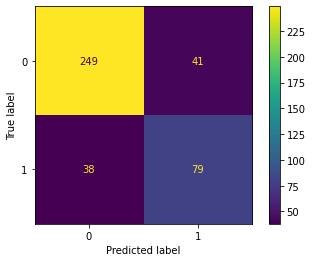

In [222]:
# Model 280x210
model_ = SVM_Model
X = input_data_Array[2]
Y = labels_Array[2]
# X = blc_data_arrays
# Y = blc_label_arrays
Y_pred = model_.predict(X)
# results = model_evaluation(Y,Y_pred)
Y_binary =  label_to_binary(Y)
Y_pred_binary =  label_to_binary(Y_pred)
results = model_evaluation(Y_binary,Y_pred_binary)
results

# **Guassian NB**

In [72]:
Model_ = sk.naive_bayes.GaussianNB()
K_Folds = sk.model_selection.KFold(n_splits=10, shuffle=True)

kfold_per_param_search = False

grid = { 
    'priors': [None],
    'var_smoothing': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]
}

test_scores = []
Param_Details = pd.DataFrame(columns=['hyper_param','test_accuracy','test_fscore','test_precision','test_recall'])

training_data = input_data_Array[0]
training_label = labels_Array[0]
x_test = input_data_Array[2]
y_test = labels_Array[2]

pbar = tqdm (sk.model_selection.ParameterGrid(grid))
for g in pbar:

    test_accuracy = []
    test_fscore = []
    test_precision = []
    test_recall = []

    if kfold_per_param_search:

        for fold, (train_index, test_index) in enumerate(K_Folds.split(training_data[2],training_label[2])):
            x_train_ = training_data[2][train_index]
            y_train_ = training_label[2][train_index]
            x_test_ = training_data[2][test_index]
            y_test_ = training_label[2][test_index]
            
            Model_.set_params(**g)
            Model_.fit(x_train_, y_train_)
            Y_pred = Model_.predict(x_test_)
            Y = y_test_

            precision_, recall_, fscore_, m = sk.metrics.precision_recall_fscore_support(Y_pred,Y , average = 'weighted')
            acc_ = sk.metrics.accuracy_score(Y_pred,Y )
            test_accuracy.append(acc_)
            test_fscore.append(fscore_)
            test_precision.append(precision_)
            test_recall.append(recall_)
            new_row = pd.Series({'hyper_param':g,'test_accuracy':test_accuracy,'test_fscore':test_fscore,'test_precision':test_precision,'test_recall':test_recall}, name='')
            Param_Details = Param_Details.append(new_row)
    else:
            x_train_ = training_data
            y_train_ = training_label
            x_test_ = x_test
            y_test_ = y_test
            
            Model_.set_params(**g)
            Model_.fit(x_train_, y_train_)
            Y_pred = Model_.predict(x_test_)
            Y = y_test_

            precision_, recall_, fscore_, m = sk.metrics.precision_recall_fscore_support(Y_pred,Y , average = 'weighted')
            acc_ = sk.metrics.accuracy_score(Y_pred,Y )
            test_accuracy.append(acc_)
            test_fscore.append(fscore_)
            test_precision.append(precision_)
            test_recall.append(recall_)
            new_row = pd.Series({'hyper_param':g,'test_accuracy':test_accuracy,'test_fscore':test_fscore,'test_precision':test_precision,'test_recall':test_recall}, name='')
            Param_Details = Param_Details.append(new_row)

Param_Details['test_accuracy_avg'] = Param_Details.apply(lambda x: mean(x.test_accuracy),axis=1)
Param_Details['test_fscore_avg'] = Param_Details.apply(lambda x: mean(x.test_fscore),axis=1)
Param_Details['test_precision_avg'] = Param_Details.apply(lambda x: mean(x.test_precision),axis=1)
Param_Details['test_recall_avg'] = Param_Details.apply(lambda x: mean(x.test_recall),axis=1)
Param_Details['test_accuracy_max'] = Param_Details.test_accuracy.apply(max)
Param_Details['test_fscore_max'] = Param_Details.test_fscore.apply(max)
Param_Details['test_precision_max'] = Param_Details.test_precision.apply(max)
Param_Details['test_recall_max'] = Param_Details.test_recall.apply(max)
best_one = np.argmax(Param_Details.test_fscore_avg)
best_param = Param_Details.iloc[best_one]['hyper_param']

GB_Model = Model_.set_params(**best_param)
GB_Model.fit(training_data, training_label)
Y_pred = GB_Model.predict(x_test)

GB_param_details = Param_Details
GB_param_details['hyper_param'] = GB_param_details['hyper_param'].apply(lambda x: json.dumps(x))
print('------- Precision recal %--------')
print(sk.metrics.classification_report(y_test,Y_pred))

100%|██████████| 14/14 [00:00<00:00, 114.27it/s]

------- Precision recal %--------
              precision    recall  f1-score   support

           0       0.50      0.65      0.57        23
           1       0.55      0.69      0.61        32
           2       0.60      0.57      0.59        72
           3       0.80      0.50      0.62         8
           4       0.38      0.66      0.48        62
           5       0.96      0.69      0.81       200
           6       0.82      0.90      0.86        10

    accuracy                           0.67       407
   macro avg       0.66      0.67      0.65       407
weighted avg       0.74      0.67      0.69       407



Nr. of Data : 
 407
Accuracy of The Model : 
 0.7764127764127764


,weights,Precision,Recall_Sensitivity,Specificity,f1_score
0,71.3%,93.4%,73.8%,87.2%,82.5%
1,28.7%,57.3%,87.2%,73.8%,69.2%
Simple Avg.,nan%,75.4%,80.5%,80.5%,75.8%
Weighted Avg.,nan%,83.1%,77.6%,83.3%,78.6%


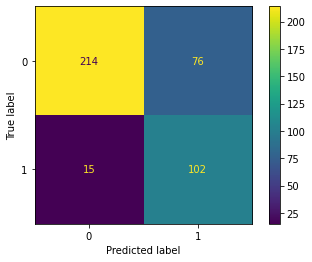

In [223]:
# Model 280x210
model_ = GB_Model
X = input_data_Array[2]
Y = labels_Array[2]
# X = blc_data_arrays
# Y = blc_label_arrays
Y_pred = model_.predict(X)
# results = model_evaluation(Y,Y_pred)

Y_binary =  label_to_binary(Y)
Y_pred_binary =  label_to_binary(Y_pred)
results = model_evaluation(Y_binary,Y_pred_binary)
results

# **Decision Tree**

In [81]:
Model_ = sk.tree.DecisionTreeClassifier(random_state=0)
K_Folds = sk.model_selection.KFold(n_splits=10, shuffle=True)

kfold_per_param_search = False

grid = { 
    'criterion' : ['gini', 'entropy','log_loss'],
    'max_depth' : [10,12,15,25,40],
    'max_features': ['auto', 'log2','sqrt'],
    'max_leaf_nodes' : [4,5,8,None],
    'class_weight' : [None, 'balanced'],
    'ccp_alpha' : [0.001,0.002,0.004]
}

test_scores = []
Param_Details = pd.DataFrame(columns=['hyper_param','test_accuracy','test_fscore','test_precision','test_recall'])

training_data = input_data_Array[0]
training_label = labels_Array[0]
x_test = input_data_Array[2]
y_test = labels_Array[2]

pbar = tqdm (sk.model_selection.ParameterGrid(grid))
for g in pbar:

    test_accuracy = []
    test_fscore = []
    test_precision = []
    test_recall = []

    if kfold_per_param_search:

        for fold, (train_index, test_index) in enumerate(K_Folds.split(training_data[2],training_label[2])):
            x_train_ = training_data[2][train_index]
            y_train_ = training_label[2][train_index]
            x_test_ = training_data[2][test_index]
            y_test_ = training_label[2][test_index]
            
            Model_.set_params(**g)
            Model_.fit(x_train_, y_train_)
            Y_pred = Model_.predict(x_test_)
            Y = y_test_

            precision_, recall_, fscore_, m = sk.metrics.precision_recall_fscore_support(Y_pred,Y , average = 'weighted')
            acc_ = sk.metrics.accuracy_score(Y_pred,Y )
            test_accuracy.append(acc_)
            test_fscore.append(fscore_)
            test_precision.append(precision_)
            test_recall.append(recall_)
            new_row = pd.Series({'hyper_param':g,'test_accuracy':test_accuracy,'test_fscore':test_fscore,'test_precision':test_precision,'test_recall':test_recall}, name='')
            Param_Details = Param_Details.append(new_row)
    else:
            x_train_ = training_data
            y_train_ = training_label
            x_test_ = x_test
            y_test_ = y_test
            
            Model_.set_params(**g)
            Model_.fit(x_train_, y_train_)
            Y_pred = Model_.predict(x_test_)
            Y = y_test_

            precision_, recall_, fscore_, m = sk.metrics.precision_recall_fscore_support(Y_pred,Y , average = 'weighted')
            acc_ = sk.metrics.accuracy_score(Y_pred,Y )
            test_accuracy.append(acc_)
            test_fscore.append(fscore_)
            test_precision.append(precision_)
            test_recall.append(recall_)
            new_row = pd.Series({'hyper_param':g,'test_accuracy':test_accuracy,'test_fscore':test_fscore,'test_precision':test_precision,'test_recall':test_recall}, name='')
            Param_Details = Param_Details.append(new_row)

Param_Details['test_accuracy_avg'] = Param_Details.apply(lambda x: mean(x.test_accuracy),axis=1)
Param_Details['test_fscore_avg'] = Param_Details.apply(lambda x: mean(x.test_fscore),axis=1)
Param_Details['test_precision_avg'] = Param_Details.apply(lambda x: mean(x.test_precision),axis=1)
Param_Details['test_recall_avg'] = Param_Details.apply(lambda x: mean(x.test_recall),axis=1)
Param_Details['test_accuracy_max'] = Param_Details.test_accuracy.apply(max)
Param_Details['test_fscore_max'] = Param_Details.test_fscore.apply(max)
Param_Details['test_precision_max'] = Param_Details.test_precision.apply(max)
Param_Details['test_recall_max'] = Param_Details.test_recall.apply(max)

best_one = np.argmax(Param_Details.test_accuracy_avg)
best_param = Param_Details.iloc[best_one]['hyper_param']

DT_Model = Model_.set_params(**best_param)
DT_Model.fit(training_data, training_label)
Y_pred = DT_Model.predict(x_test)
DT_param_details = Param_Details
DT_param_details['hyper_param'] = DT_param_details['hyper_param'].apply(lambda x: json.dumps(x))
print('------- Precision recal %--------')
print(sk.metrics.classification_report(y_test,Y_pred))

100%|██████████| 1080/1080 [00:08<00:00, 131.81it/s]

------- Precision recal %--------
              precision    recall  f1-score   support

           0       0.57      0.57      0.57        23
           1       0.50      0.75      0.60        32
           2       0.54      0.64      0.59        72
           3       0.80      0.50      0.62         8
           4       0.54      0.42      0.47        62
           5       0.87      0.82      0.85       200
           6       0.60      0.60      0.60        10

    accuracy                           0.70       407
   macro avg       0.63      0.61      0.61       407
weighted avg       0.71      0.70      0.70       407



Nr. of Data : 
 407
Accuracy of The Model : 
 0.8181818181818182


,weights,Precision,Recall_Sensitivity,Specificity,f1_score
0,71.3%,87.5%,86.9%,69.2%,87.2%
1,28.7%,68.1%,69.2%,86.9%,68.6%
Simple Avg.,nan%,77.8%,78.1%,78.1%,77.9%
Weighted Avg.,nan%,81.9%,81.8%,74.3%,81.9%


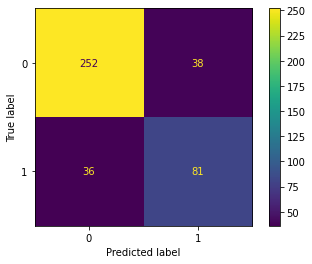

In [224]:
# Model 280x210
model_ = DT_Model
X = input_data_Array[2]
Y = labels_Array[2]
# X = blc_data_arrays
# Y = blc_label_arrays
Y_pred = model_.predict(X)
# results = model_evaluation(Y,Y_pred)

Y_binary =  label_to_binary(Y)
Y_pred_binary =  label_to_binary(Y_pred)
results = model_evaluation(Y_binary,Y_pred_binary)

results

# **MLP**

In [131]:
class Model_Training2:

    def __init__(self, Net, LR, batch_size , Momentum, epochs, weight_decay, loss_func, opt_func, X_train, Y_train, X_valid, Y_valid, print_epochs):    
        
        self.model = Net()
        
        if opt_func is torch.optim.Adam:
            self.opt = opt_func(self.model.parameters(), lr=LR, weight_decay=weight_decay)
        else:
            self.opt = opt_func(self.model.parameters(), lr=LR,momentum=Momentum, weight_decay=weight_decay)

        
        self.loss_func = loss_func()
        # self.opt = optimizer
        self.epochs = epochs
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_valid = X_valid
        self.Y_valid = Y_valid
        self.batch_size = batch_size
        self.Epochs_Train_loss = []
        self.Epochs_Train_Acc = []
        self.Epochs_Val_loss = []
        self.Epochs_Val_Acc = []   
        self.print_epochs = print_epochs

    def train(self):
        
    
        model = self.model
        loss_func = self.loss_func 
        opt = self.opt 
        batch_size = self.batch_size
        nr_of_steps_train =  self.X_train.shape[0]//self.batch_size 
        nr_of_steps_valid =  self.X_valid.shape[0]//self.batch_size 

        for epoch in range(0,self.epochs):
            start_time=time.time()
            steps_train_loss = []
            steps_train_Acc = []
            steps_val_loss = []
            steps_val_Acc = []
            train_epoch_loss = 0.0

            for i in range(1, nr_of_steps_train):
                
                X = self.X_train[i* batch_size:(i+1) * batch_size]
                Y = self.Y_train[i * batch_size:(i+1) * batch_size]
                # Reset gradients
                opt.zero_grad()
                model.train()
                # Forward pass
                y_pred = model.forward(X)
                # Loss calculation

                # print('Y shape: ',Y.shape)
                # print('y_pred shape: ',y_pred.shape)
                loss = loss_func(y_pred, Y.argmax(dim=1))
                # loss = loss_func(y_pred.argmax(dim=1), Y.argmax(dim=1))
                # loss = loss_func(y_pred, Y)
                # Backward pass
                loss.backward()
                opt.step()
                nr_of_corrects = (y_pred.argmax(dim=1) == Y.argmax(dim=1)).sum().item()

                step_acc = nr_of_corrects / batch_size
                steps_train_Acc.append(step_acc)
                steps_train_loss.append(loss.item())
            
            # Epochs validation 
            for j in range(0,nr_of_steps_valid):
                val_X = self.X_valid[j*batch_size:(j+1)*batch_size]
                val_Y = self.Y_valid[j*batch_size:(j+1)*batch_size]
                model.eval()
                val_outputs = model.forward(val_X)
                val_epoch_loss = loss_func(val_outputs, val_Y.argmax(dim=1))
                nr_of_corrects = (val_outputs.argmax(dim=1) == val_Y.argmax(dim=1)).sum().item()
                step_acc = nr_of_corrects / batch_size
                steps_val_Acc.append(step_acc)
                steps_val_loss.append(val_epoch_loss.item())

            # Epoch Performance Metrics
            train_epoch_loss = mean(steps_train_loss)
            train_epoch_Acc = mean(steps_train_Acc)
            self.Epochs_Train_loss.append(train_epoch_loss)
            self.Epochs_Train_Acc.append(train_epoch_Acc)   
            val_epoch_loss = mean(steps_val_loss)
            val_epoch_Acc = mean(steps_val_Acc)
            self.Epochs_Val_loss.append(val_epoch_loss)
            self.Epochs_Val_Acc.append(val_epoch_Acc)
            End_time = time.time()   
            if self.print_epochs:
                print('[Epoch: {}]  , Train_loss: {:.1f} , Train_Acc: {:.1%}, Val_loss: {:.1f} , Val_Acc: {:.1%} , run time: {}'
                .format(epoch , train_epoch_loss , train_epoch_Acc , val_epoch_loss , val_epoch_Acc, np.round(End_time - start_time, 2)))

In [132]:
model_test = MLP_Nets.Net2()
X_ = input_data_Tensor[2][:100]
Y = labels_OneHot_Tensor[2][:100]
y_pred = model_test(X_)
y_pred.shape

torch.Size([100, 7])

In [149]:
Net = [ MLP_Nets.Net1]
LR = [0.0022, 0.003]
batch_size = [ 16,24]
Momentum = [0.55,0.9]
epochs = [400]
weight_decay = [0, 0.000001]
loss_func  =  [nn.CrossEntropyLoss]
opt_func = [torch.optim.SGD, ]

X_train = input_data_Tensor[0]
Y_train = labels_OneHot_Tensor[0]
X_valid = input_data_Tensor[1]
Y_valid = labels_OneHot_Tensor[1]
X_test = input_data_Tensor[2]
Y_test = labels_OneHot_Tensor[2]

grid = {
    'Net' : Net
    ,'LR' : LR
    ,'batch_size' : batch_size
    ,'Momentum' : Momentum
    ,'epochs' : epochs
    ,'weight_decay' :weight_decay
    ,'loss_func'  :loss_func
    ,'opt_func' : opt_func
}
params = sk.model_selection.ParameterGrid(grid)

In [150]:
print_epochs = False

Param_Details = pd.DataFrame(columns=['hyper_param','train_accuracy','valid_accuracy','test_accuracy','train_fscore','valid_fscore','test_fscore','train_precision','valid_precision','test_precision'
                                    ,'train_recall','valid_recall','test_recall'])

Max_train_Acc = 0  
Max_valid_Acc = 0 
Max_test_Acc = 0  

pbar = tqdm(params)
for p in pbar:
    Model_ = Model_Training2(**p, X_train = X_train , Y_train = Y_train, X_valid = X_valid, Y_valid= Y_valid, print_epochs=print_epochs)
    torch.manual_seed(0)
    Model_.model
    Model_.train()
    
    model_ = Model_.model.eval()

    # X_train = X_train
    # Y_train = Y_train
    # X_valid = X_valid
    # Y_valid = Y_valid
        
    # Train
    Y_pred = model_(X_train).argmax(axis=1)
    Y = Y_train.argmax(axis=1)
    train_accuracy = sk.metrics.accuracy_score(Y_pred,Y )
    train_precision, train_recall, train_fscore, m = sk.metrics.precision_recall_fscore_support(Y_pred,Y , average = 'weighted')

    # Valid
    Y_pred = model_(X_valid).argmax(axis=1)
    Y = Y_valid.argmax(axis=1)
    valid_accuracy = sk.metrics.accuracy_score(Y_pred,Y )
    valid_precision, valid_recall, valid_fscore, m = sk.metrics.precision_recall_fscore_support(Y_pred,Y , average = 'weighted')

    # Test
    Y_pred = model_(X_test).argmax(axis=1)
    Y = Y_test.argmax(axis=1)
    test_accuracy = sk.metrics.accuracy_score(Y_pred,Y )
    test_precision, test_recall, test_fscore, m = sk.metrics.precision_recall_fscore_support(Y_pred,Y , average = 'weighted')

    if train_accuracy > Max_train_Acc: Max_train_Acc = train_accuracy
    if valid_accuracy > Max_valid_Acc: Max_valid_Acc = valid_accuracy
    if test_accuracy > Max_test_Acc: Max_test_Acc = test_accuracy

    pbar.set_description(f'Max_Train_Acc: {Max_train_Acc:.1%}, Max_Valid_Acc: {Max_valid_Acc:.1%}, Max_Test_Acc: {Max_test_Acc:.1%} ')
    pbar.set_postfix_str(f'Train_Acc: {train_accuracy:.1%} , Valide_Acc: {valid_accuracy:.1%} , Test_Acc: {test_accuracy:.1%}')

    new_row = pd.Series({'hyper_param':p,'train_accuracy':train_accuracy,'valid_accuracy':valid_accuracy,'test_accuracy':test_accuracy,'train_fscore':train_fscore,'valid_fscore':valid_fscore,'test_fscore':test_fscore
    ,'train_precision':train_precision,'valid_precision':valid_precision,'test_precision':test_precision,'train_recall':train_recall,'valid_recall':valid_recall,'test_recall':test_recall}, name='')
    Param_Details = Param_Details.append(new_row)

best_one = np.argmax(Param_Details.test_accuracy)
best_param = Param_Details.iloc[best_one]['hyper_param']

MLP_param_details = Param_Details
MLP_param_details['hyper_param'] = MLP_param_details['hyper_param'].apply(lambda x: str(x))

MLP_Model = Model_Training2(**best_param, X_train = X_train, Y_train = Y_train, X_valid = X_valid, Y_valid= Y_valid,print_epochs=print_epochs)
np.random.seed(0)
random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
MLP_Model.train()

Max_Train_Acc: 94.4%, Max_Valid_Acc: 76.9%, Max_Test_Acc: 71.3% : 100%|██████████| 16/16 [04:52<00:00, 18.25s/it, Train_Acc: 93.3% , Valide_Acc: 74.2% , Test_Acc: 70.5%]


Nr. of Data : 
 407
Accuracy of The Model : 
 0.8181818181818182


,weights,Precision,Recall_Sensitivity,Specificity,f1_score
0,71.3%,88.0%,86.2%,70.9%,87.1%
1,28.7%,67.5%,70.9%,86.2%,69.2%
Simple Avg.,nan%,77.8%,78.6%,78.6%,78.1%
Weighted Avg.,nan%,82.1%,81.8%,75.3%,82.0%


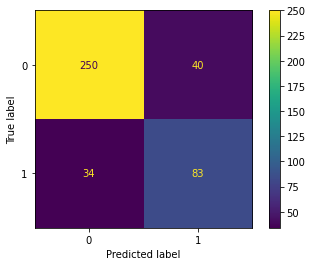

In [225]:
# Model 280x210
model_ = MLP_Model.model.eval()
X = input_data_Tensor[2]
Y = labels_Array[2]
# X = blc_data_Tensor
# Y = blc_label_arrays
Y_pred = model_(X).argmax(dim=1)
# results = model_evaluation(Y,Y_pred)

Y_binary =  label_to_binary(Y)
Y_pred_binary =  label_to_binary(Y_pred)
results = model_evaluation(Y_binary,Y_pred_binary)

results

In [213]:
np.bincount(Y), np.bincount(Y_pred)

(array([ 23,  32,  72,   8,  62, 200,  10]),
 array([ 23,  40,  80,   6,  60, 187,  11]))

In [215]:
Y_binary =  label_to_binary(Y)
Y_pred_binary =  label_to_binary(Y_pred)

In [216]:
np.bincount(Y_binary), np.bincount(Y_pred_binary)

(array([290, 117]), array([284, 123]))

In [203]:
def label_to_binary(entry):
    return remap[entry] if entry in remap else entry
label_to_binary = np.vectorize(label_to_binary)

Y_binary =  label_to_binary(Y)

In [207]:
np.bincount(Y_pred_binary) , np.bincount(Y_pred)

(array([2454, 1379]), array([ 364,  524,  582,  116,  491, 1600,  156]))

In [205]:
Y_pred_binary =  label_to_binary(Y_pred)

In [209]:
np.bincount(Y_pred) , np.bincount(Y)

(array([ 364,  524,  582,  116,  491, 1600,  156]),
 array([ 364,  524,  582,  116,  491, 1600,  156]))